
# MSM of Mueller potential
In this example we work with the Muller potential, introduced by K. Muller and L. D. Brown in *Theo. Chim. Acta (Berl.)* **53**, 75-93 (1979):
\begin{equation}
    V(x,y) = \sum_{j=1}^{4}A_{j} \cdot \exp(a_{j}(x-X_{j}^{0})^{2}+b_{j}(x-X_{j}^{0})(y-Y_{j}^{0})+c_{j}(y-Y_{j}^{0})^{2})
\end{equation}
where $a$=(-1,-1,-6.5,0.7); $b$=(0, 0, 11, 0.6); $c$=(-10,-10,-6.5, 0.7); $A$=(-200,-100,-170, 15); $X^{0}$=(1, 0,-0.5,-1); $Y^{0}$=(0, 0.5, 1.5, 1)

We first use `OpenMM` to generate the data and then analyze it user `MasterMSM`.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import h5py
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
from collections import OrderedDict

### Data generation
First of all we import the `mueller` module, which contains a class (borrowed from [Robert Mc Gibbon](https://gist.github.com/rmcgibbo/6094172)) that runs the simulations using [OpenMM](http://openmm.org/).

In [2]:
import mueller
import simtk.openmm as mm

First we set a number of parameters for the run. 

In [3]:
from simtk.unit import kelvin, picosecond, femtosecond, nanometer, dalton
# each particle is totally independent, propagating under the same potential
mass = 1.0*dalton
temperature = 750 * kelvin
friction = 50/picosecond
timestep = 10.0*femtosecond

In [4]:
# Choose starting conformations uniform on the grid between (-1.5, -0.2) and (1.2, 2)
nParticles = 4
startingPositions = (np.random.rand(nParticles, 3)*np.array([2.7, 1.8, 1])) \
            + np.array([-1.5, -0.2, 0])
    
system = mm.System()
mullerforce = mueller.MullerForce()
for i in range(nParticles):
    system.addParticle(mass)
    mullerforce.addParticle(i, [])
system.addForce(mullerforce)

integrator = mm.LangevinIntegrator(temperature, friction, timestep)
context = mm.Context(system, integrator)
context.setPositions(startingPositions)
context.setVelocitiesToTemperature(temperature)

In [5]:
import cProfile, pstats, io
from pstats import SortKey

# Run the simulation
traj = []
for i in range(int(1e7)):
    coords = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)
    integrator.step(50)
    traj.append(coords)

SystemError: <built-in function Context_getState> returned a result with an error set

In [6]:
for i in range(nParticles):
    data = np.vstack([x[i] for x in traj])
    h5file = "data/mueller_test_n%i.h5"%i
    with h5py.File(h5file, "w") as hf:
        hf.create_dataset("data", data=data)

### Data analysis

Download brownian trajectory from [here](https://drive.google.com/drive/folders/1XXlBtAvd-GPf1pzaonolJgyWRa_Xel6t), and read the latter by using trajectory from COSSIO generator.

In [7]:
import h5py
i = 0
h5file = "data/mueller_test_n%g.h5"%i
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

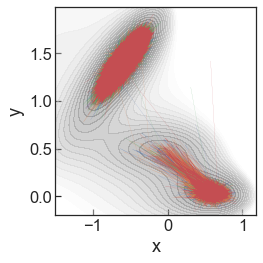

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
mullerforce.plot(ax=ax, cmap='binary_r', levels=np.arange(-150,50,10))
for i in range(nParticles):
    h5file = "data/mueller_test_n%g.h5"%i
    f = h5py.File(h5file, 'r')
    data = np.array(f['data'])
    f.close()
    ax.plot(data[:-1:10,0], data[:-1:10,1], lw=0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()

### Trajectory analysis and assignment
We discretize the trajectory by a 2D binning, so the mueller potential is divided in microstates (plot 1). In consequence, both x and y coordinates merge onto a s coordinate (plot 2).

In [9]:
def discretize(data):
    # Discretize trajectory and plot onto the mueller potential
    discret = np.zeros(data.shape[0])
    statistic, x_edge, y_edge, binnumber = \
            scipy.stats.binned_statistic_2d(data[:,0], data[:,1],\
            discret, 'count', \
            bins = [np.linspace(-1.5, 1, 6), np.linspace(-0.5, 2, 6)], \
                        expand_binnumbers=False)
    return binnumber

In [10]:
data.shape

(5013178, 3)

(5013178, 3)
(5013178, 3)
(5013178, 3)
(5013178, 3)


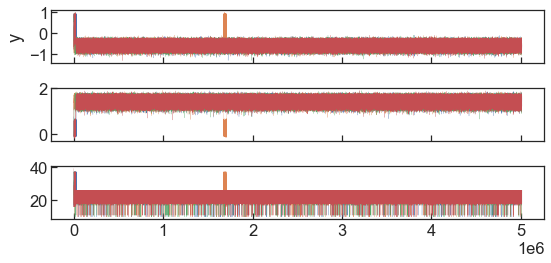

In [11]:
binned_trajs = []
fig, ax = plt.subplots(3,1, figsize=(8,4), sharex=True)
for i in range(nParticles):
    h5file = "data/mueller_test_n%g.h5"%i
    f = h5py.File(h5file, 'r')
    data = np.array(f['data'])
    f.close()
    print (data.shape)
    binnumber = discretize(data)
    binned_trajs.append(list(binnumber))
    ax[0].plot(data[:,0], lw=0.2)
    ax[1].plot(data[:,1], lw=0.2)
    ax[2].plot(binnumber, lw=0.2)
#ax[0].set_xlim(0, 500000)
ax[0].set_ylabel('x')
ax[0].set_ylabel('y')
plt.tight_layout()

In [24]:
data[:,1]

array([1.46683872, 1.48307276, 1.53297031, ..., 1.44275713, 1.33185172,
       1.51710415])

In [25]:
len(binnumber), len(data)
binnumber

array([25, 25, 26, ..., 18, 18, 19])

### MSM: convergence test
First, we build an instance of `TimeSeries` class to find the strongly connected states corresponding to the assignment shown above. Then, we use the `SuperMSM` class to study the dependence of the relaxation times, $\tau_i$, on the lag time $\Delta t$ adopted to build the transition matrix.

In [169]:
# MASTER EQUATION MODEL
from mastermsm.trajectory import traj

trajectories = [traj.TimeSeries(distraj=binned_trajs[i], dt=1) \
           for i in range(nParticles)]
[trajectories[i].find_keys() for i in range(nParticles)]

[None, None, None, None]

In [178]:
from mastermsm.msm import msm
msm_2D = msm.SuperMSM(trajectories,sym=False)

     # states: 15


In [ ]:
msm_2D.convergence_test(time=[1, 2, 5, 10, 20, 50], error=False)

In [ ]:
fig, ax = plt.subplots()
for i in range(0,6):
    tau_vs_lagt = np.array([[x, msm_2D.msms[x].tauT[i]] \
               for x in sorted(msm_2D.msms.keys())])
    ax.plot(tau_vs_lagt[:,0], tau_vs_lagt[:,1], marker='o', ms=7)
ax.set_xlabel(r'$\Delta$t ', fontsize=16)
ax.set_ylabel(r'$\tau_i$', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between(10**np.arange(-1,4,0.2), 1e-1, 10**np.arange(-1,4,0.2), facecolor='lightgray', alpha=0.5)
ax.set_ylim(1e-1,1000)
ax.set_xlim(0.7,1400)
plt.tight_layout()

### MSM: validation
Once a proper lag time is chosen, we generate a MSM and plot the autocorrelation corresponding to the left eigenvectors (Buchete et al. JPCB 2008), as well as the spectrum of (logarithm of) relaxation times.

 symmetrizing


<function matplotlib.pyplot.show(*args, **kw)>

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


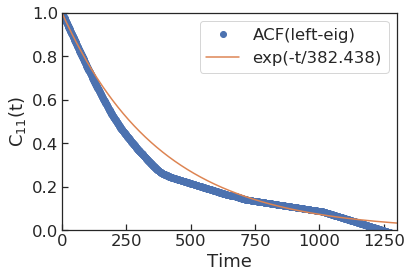

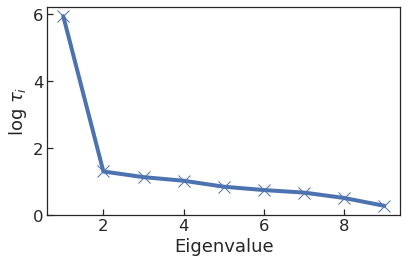

In [6]:
lagt=10
msm_2D.do_msm(lagt)
msm_2D.msms[lagt].do_trans(evecs=True)

# VALIDATION - AUTOCORRELATION FUNCTION (acf)
acf = msm_2D.msms[lagt].acf_mode()
time = np.arange(len(acf[1]))*msm_2D.data[0].dt
fig, ax = plt.subplots()
ax.plot(time, acf[1], 'o', label='ACF(left-eig)')
ax.plot(time,np.exp(-time*1./msm_2D.msms[lagt].tauT[0]), \
            label='exp(-t/%5.3f)' % msm_2D.msms[lagt].tauT[0])
ax.set_ylim(0,1)
ax.set_xlim(0,1300)
ax.set_xlabel('Time')
ax.set_ylabel('C$_{11}$(t)')
ax.legend()
plt.show

# Spectrum of relaxation times
fig, ax = plt.subplots()
ax.plot(range(1,len(msm_2D.msms[lagt].tauT)+1), \
            np.log(msm_2D.msms[lagt].tauT), 'x-', markersize=12, linewidth=4)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'log $\tau_i$')
plt.tight_layout()
plt.show

The first mode captured by $\lambda_1$ is significantly slower than the others. That mode, which is described by the right eigenvector $\psi^R_1$ as the transition between the two main minima. Next plots correspond to the eigenvector and its projection on the mueller potential.

<function matplotlib.pyplot.show(*args, **kw)>

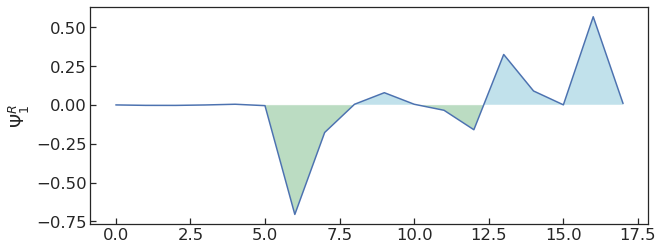

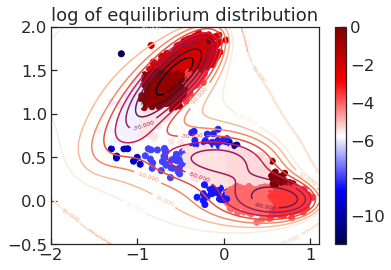

In [10]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(msm_2D.msms[lagt].rvecsT[:,1])
ax.fill_between(range(len(msm_2D.msms[lagt].rvecsT[:,1])), 0, \
                msm_2D.msms[lagt].rvecsT[:,1], \
                where=msm_2D.msms[lagt].rvecsT[:,1]>0,\
                facecolor='c', interpolate=True,alpha=.4)
ax.fill_between(range(len(msm_2D.msms[lagt].rvecsT[:,1])), 0, \
                msm_2D.msms[lagt].rvecsT[:,1], \
                where=msm_2D.msms[lagt].rvecsT[:,1]<0,\
                facecolor='g', interpolate=True,alpha=.4)
ax.set_ylabel("$\Psi^R_1$")
plt.show

# 2D projection
binnumber2 = np.zeros(len(data[:,1]))
for i in range(len(binnumber)-1):
    j = binnumber[i]
    for k in range(len(msm_2D.msms[lagt].keep_keys)-1):
        if j==msm_2D.msms[lagt].keep_keys[k]:
            binnumber2[i] = np.log(msm_2D.msms[lagt].peqT[k])
            break
y = np.linspace(-0.5,2.,200)
x = np.linspace(-2.,1.1,200)
M = np.zeros((len(x), len(y)))
lines = []
for i, x_i in enumerate(x):
    for j, y_i in enumerate(y):
        aux = fmueller(x_i,y_i)
        if aux<100: M[i, j] = aux
X, Y = np.meshgrid(x,y)
fig, ax = plt.subplots()
levels = np.arange(-130.0, 40.0, 20)
CS = ax.contour(X, Y, M.T, levels)
ax.clabel(CS, inline=0.9, fontsize=6)
cmaps = OrderedDict()
cmaps['Diverging'] = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
plt.scatter(data[:,1],data[:,2],c=binnumber2,cmap=plt.get_cmap('seismic'))
plt.colorbar()
plt.title('log of equilibrium distribution')
plt.show


# HDBSCAN clustering
Since the 2D binning used above in order to assign discrete states does not take into account the potential form, in the following a density-based clustering is employed instead. Namely, the HDBSCAN algorithm is suitable to deal with any shape clusters with different densities. The latter must be installed from [here](https://anaconda.org/conda-forge/hdbscan) before going on.

### Discretization
Clusters are built from trajectory data. Then, we refine noise and analyze if the resulting condensed tree plot makes sense for our system.

<function matplotlib.pyplot.show(*args, **kw)>

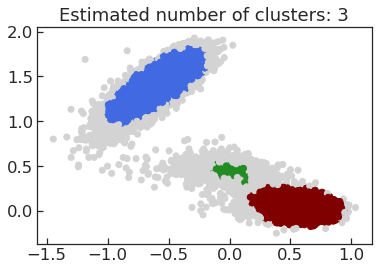

In [8]:
import hdbscan
X = data[:,[1,2]]
hb = hdbscan.HDBSCAN(min_cluster_size=200).fit(X)
labels = hb.labels_
for i, x_i in enumerate(labels):
    if hb.probabilities_[i] < 0.1:
        labels[i] = -1
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', \
        'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'lightgray']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(X[:,0],X[:,1], c=vectorizer(labels))
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

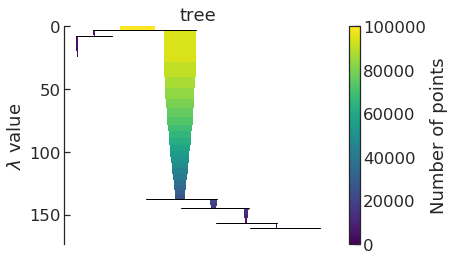

In [9]:
hb.condensed_tree_.plot()
plt.title('tree')
plt.show

### MSM validation
We compare the relaxation times obtained from the transition matrix with those corresponding to the 2D binning shown above. Obviously, since there are three clusters in HDBSCAN, we obtain two possible transitions.

     # states: 3
 symmetrizing


<function matplotlib.pyplot.show(*args, **kw)>

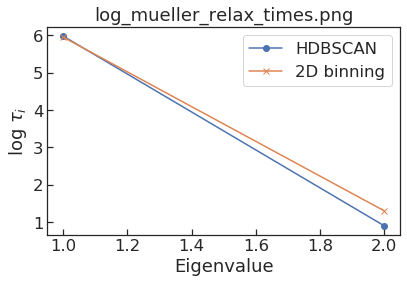

In [25]:
# remove noise (label=-1) to obtain a trajectory for MasterMSM
last = labels[0]
for i, x_i in enumerate(labels):
    if x_i == -1:
        labels[i] = last
    else:
        last = x_i
labels[0] = labels[1]

cluster = traj.TimeSeries(distraj=list(labels), dt=1)
cluster.find_keys()
cluster.keys.sort()
msm_cluster = msm.SuperMSM([cluster],sym=True)
lagt=5 # lag time
msm_cluster.do_msm(lagt)
msm_cluster.msms[lagt].do_trans(evecs=True)

fig, ax = plt.subplots()
ax.plot(range(1,len(msm_cluster.msms[lagt].tauT)+1), \
        np.log(msm_cluster.msms[lagt].tauT), 'o-', label='HDBSCAN')
# Note for msm_2D we chose lagt=10
ax.plot(range(1,len(msm_cluster.msms[lagt].tauT)+1), \
        np.log(msm_2D.msms[10].tauT[:len(msm_cluster.msms[lagt].tauT)]), \
        'x-', label='2D binning')
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'log $\tau_i$')
plt.tight_layout()
plt.legend()
plt.title('log_mueller_relax_times.png')
plt.show

### RATE matrix analysis
The simplicity of this discretization with only three states allows us to employ the Maximum-Likelihood Propagator-Based (MLPB) method in order to compute rate matrix and corresponding eigenvectors.

MLPB optimization of rate matrix:
 START

 END of cycle 1
   acceptance :0.307667
[[-1.37619690e-04  1.18710145e-03  1.57886982e-02]
 [ 7.19015555e-05 -2.47374657e-02  3.42696107e-01]
 [ 6.57181349e-05  2.35503642e-02 -3.58484805e-01]]
   L old = 4642.387627925874 ; L new: 4641.172922435843
   improvement :0.000261655

 END of cycle 2
   acceptance :0.239889
[[-1.36489284e-04  1.35686840e-03  1.74897371e-02]
 [ 7.07711493e-05 -2.66089086e-02  3.50520194e-01]
 [ 6.57181349e-05  2.52520402e-02 -3.68009931e-01]]
   L old = 4642.3395002548095 ; L new: 4639.164496564909
   improvement :0.000683923

 END of cycle 3
   acceptance :0.234556
[[-1.36489284e-04  1.36552703e-03  1.76200650e-02]
 [ 7.07711493e-05 -2.66117897e-02  3.50812712e-01]
 [ 6.57181349e-05  2.52462627e-02 -3.68432777e-01]]
   L old = 4640.95746289116 ; L new: 4639.167333640139
   improvement :0.000385724


<function matplotlib.pyplot.show(*args, **kw)>

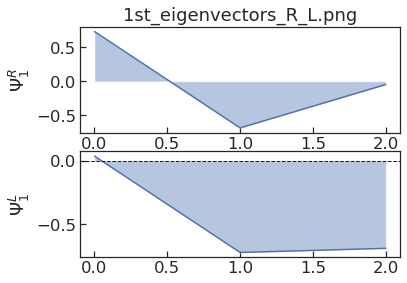

In [22]:
msm_cluster.do_lbrate()
msm_cluster.msms[lagt].do_rate(method='MLPB', evecs=True, init=msm_cluster.lbrate)
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=False)
plt.subplots_adjust(wspace=0.9, hspace=0.9)
ax[0].plot(msm_cluster.msms[lagt].rvecsK[:,1])
ax[0].fill_between(range(len(msm_cluster.msms[lagt].rvecsK[:,1])), \
        0, msm_cluster.msms[lagt].rvecsK[:,1], alpha=.4)
ax[1].plot(msm_cluster.msms[lagt].lvecsK[:,1])
ax[1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1].fill_between(range(len(msm_cluster.msms[lagt].lvecsK[:,1])), \
        msm_cluster.msms[lagt].lvecsK[:,1], 0, alpha=.4)
ax[0].set_ylabel("$\Psi^R_1$")
ax[1].set_ylabel("$\Psi^L_1$")
plt.tight_layout(h_pad=0)
ax[0].set_title('1st_eigenvectors_R_L.png')
plt.show

### COUNT and TRANSITION matrices
Count and transition matrices give us an intuition of the dynamics for this simple system. Remind the former is strongly dependent on the lag time.

<function matplotlib.pyplot.show(*args, **kw)>

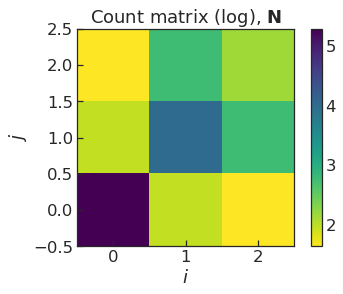

In [23]:
plt.figure()
plt.imshow(np.log10(msm_cluster.msms[lagt].count), \
    interpolation='none', cmap='viridis_r', origin='lower')
plt.ylabel('$\it{j}$')
plt.xlabel('$\it{i}$')
plt.colorbar()
plt.title('Count matrix (log), $\mathbf{N}$')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

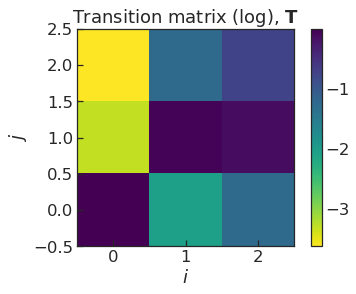

In [24]:
plt.imshow(np.log10(msm_cluster.msms[lagt].trans), interpolation='none', \
    cmap='viridis_r', origin='lower')
plt.ylabel('$\it{j}$')
plt.xlabel('$\it{i}$')
plt.colorbar()
plt.title('Transition matrix (log), $\mathbf{T}$')
plt.show